# Step 1: Import Libraries and Load Datasets

In [54]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from datetime import datetime, timedelta, date
import os
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
## warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the datasets
players_df = pd.read_csv('2021-2022 Football Player Stats.csv', encoding='ISO-8859-1', delimiter=';')
players_2_df = pd.read_csv('2022-2023 Football Player Stats.csv', encoding='ISO-8859-1', delimiter=';')
print('players_df.shape :', players_df.shape)
print('players_2_df.shape :', players_2_df.shape)

players_df.shape : (2921, 143)
players_2_df.shape : (2689, 124)


# Step 2: Data Preparation

## The two player datasets need to be aligned with same columns 

In [5]:
# Identifying the common columns in both datasets
common_columns = players_df.columns.intersection(players_2_df.columns)

# Creating new datasets with only the common columns
players_df = players_df[common_columns]
players_2_df = players_2_df[common_columns]

# Displaying the number of common columns and the first few rows of the aligned datasets
num_common_columns = len(common_columns)
(players_df.head(), players_2_df.head(), num_common_columns)

(   Rk             Player Nation Pos          Squad            Comp   Age  Born  MP  Starts   Min   90s  Goals  Shots   SoT  SoT%  G/Sh  G/SoT  ShoDist  ShoFK  ShoPK  PKatt  PasTotCmp  PasTotAtt  PasTotCmp%  PasTotDist  PasTotPrgDist  PasShoCmp  PasShoAtt  PasShoCmp%  PasMedCmp  PasMedAtt  PasMedCmp%  PasLonCmp  PasLonAtt  PasLonCmp%  Assists  PasAss  Pas3rd   PPA  CrsPA  PasProg  PasAtt  PasLive  PasDead  PasFK    TB    Sw  PasCrs    CK  CkIn  CkOut  CkStr    TI  PasCmp  PasOff  PasBlocks   SCA  ScaPassLive  ScaPassDead  ScaDrib  ScaSh  ScaFld  ScaDef   GCA  GcaPassLive  GcaPassDead  GcaDrib  GcaSh  GcaFld  GcaDef   Tkl  TklWon  TklDef3rd  TklMid3rd  TklAtt3rd  TklDri  TklDriAtt  TklDri%  TklDriPast  Blocks  BlkSh  BlkPass   Int  Tkl+Int   Clr  Err  Touches  TouDefPen  TouDef3rd  TouMid3rd  TouAtt3rd  TouAttPen  TouLive  Carries  CarTotDist  CarPrgDist  CarProg  Car3rd   CPA  CarMis  CarDis   Rec  RecProg  CrdY  CrdR  2CrdY   Fls   Fld   Off   Crs  TklW  PKwon  PKcon    OG  Recov  \
 

In [6]:
players_df.dropna(subset=['Age'], inplace=True)
players_df['Age'] = players_df['Age'].astype(int)

## Player datasets values to be adjusted from rate per 90s to the actual number

In [7]:
# Define the starting column index for adjustments (skip first 7 columns)
start_index = 12
df1 = players_df.copy()
# Iterate through each column in the DataFrame
for col in df1.columns[start_index:]:
    # Check if the column name does not end with '%'
    if not col.endswith('%'):
        # Multiply the column values by the values in the '90s' column
        df1[col] = round((df1[col] * df1['90s'])).astype(int)

# Now, DataFrame 'df22' contains the adjusted values
df1.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,90s,Goals,Shots,SoT,SoT%,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotCmp%,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasShoCmp%,PasMedCmp,PasMedAtt,PasMedCmp%,PasLonCmp,PasLonAtt,PasLonCmp%,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasAtt,PasLive,PasDead,PasFK,TB,Sw,PasCrs,CK,CkIn,CkOut,CkStr,TI,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDri%,TklDriPast,Blocks,BlkSh,BlkPass,Int,Tkl+Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Max Aarons,ENG,DF,Norwich City,Premier League,22,2000,34,32,2881,32.0,0,13,2,15.4,0,0,656,0,0,0,1088,1440,75.5,18371,6874,560,621,90.0,419,544,77.0,98,217,45.2,2,19,50,36,8,94,1440,1101,339,27,2,19,45,0,0,0,0,311,1088,7,56,38,27,2,3,4,2,0,5,5,0,0,0,0,0,69,37,50,19,0,37,58,63.8,21,86,22,64,56,125,70,0,1856,162,746,762,480,29,1530,1085,6381,3894,174,53,13,27,30,1037,41,8,0,0,31,59,1,45,37,0,2,1,177,15,51,22.7
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,1987,34,34,2983,33.1,2,18,6,33.3,4,11,619,0,0,0,1281,1556,82.4,27665,9529,338,377,89.9,741,828,89.4,187,303,61.7,0,8,81,6,0,90,1556,1456,100,81,0,55,2,0,0,0,0,14,1281,5,29,21,14,0,3,1,0,3,1,0,0,1,0,0,0,62,46,41,20,1,13,27,48.1,14,62,26,36,103,165,106,0,1897,274,1086,851,96,28,1804,1182,6776,3823,91,24,0,15,13,1202,12,5,1,0,43,24,0,2,46,0,1,0,224,67,45,59.8
2,3,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,2000,31,29,2462,27.4,1,18,5,27.8,2,5,556,0,0,0,1532,1671,91.7,28312,5053,616,660,93.5,707,745,94.9,184,214,86.0,0,15,77,13,1,81,1671,1652,20,16,1,22,10,0,0,0,0,4,1532,2,23,40,30,0,0,4,4,2,1,1,0,0,0,0,0,55,34,25,25,5,19,59,32.2,40,27,1,26,51,106,15,0,1929,55,622,1145,299,17,1915,1466,6754,2913,78,20,4,23,40,1485,47,12,3,2,45,35,0,10,34,0,0,0,240,24,24,50.0
3,4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,1993,34,34,2956,32.8,0,30,7,23.3,0,0,741,0,0,0,1335,1633,81.6,25610,6757,535,604,88.6,567,643,87.9,205,308,66.6,2,30,127,19,6,137,1633,1607,28,21,6,49,26,1,0,0,0,5,1335,7,55,66,49,2,1,1,7,6,5,4,0,0,0,1,0,117,73,49,56,12,59,163,36.2,104,55,3,52,84,201,11,0,2020,22,449,1322,380,15,1998,1499,5638,2834,94,37,3,28,48,1410,61,9,0,0,46,68,1,26,73,0,0,0,291,14,14,50.0
4,5,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,2000,1,1,45,0.5,0,0,0,0.0,0,0,0,0,0,0,2,6,33.3,24,0,1,2,50.0,1,3,33.3,0,0,0.0,0,0,0,0,0,0,6,6,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1,1,0,1,0,0,0,0,12,0,0,5,9,3,12,9,59,9,0,1,0,4,0,8,2,0,0,0,1,0,0,1,0,0,0,0,2,1,0,100.0


In [8]:
print('df1.shape :', df1.shape)


df1.shape : (2920, 119)


In [9]:
# SAVE THE TWO CLEANED PLAYER DATASETS

df1.to_csv("players_2021-2022_cleaned.csv", index=False)
print('Cleaned Datasets are Saved')

Cleaned Datasets are Saved


In [10]:
# FOCUS THE EDA ON PLAYERS WHO PLAYED ENOUGH MATCHES
df1 = df1.loc[:,['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'MP', 'Starts', 'Min', '90s', 
               'Goals', 'Shots', 'SoT', 'Assists', 'Crs', 'PasTotCmp', 'Tkl', 'TklWon', 'Int', 'Blocks', 'Clr', 'AerWon']]

# Rename some selected columns
cols = ['Player', 'Nation', 'Position', 'Squad', 'Competition', 'Age', 'Matches_Played', 'Starts', 'Minutes', '90s', 
        'Goals', 'Shots', 'Shots_onTarget', 'Assists', 'Crosses', 'Pass_Completed', 'Tackles', 'Tackles_Won', 
        'Interceptions', 'Blocks', 'Clearances', 'Aerials_Won']
df1.columns = cols

print(df1.columns)


Index(['Player', 'Nation', 'Position', 'Squad', 'Competition', 'Age', 'Matches_Played', 'Starts', 'Minutes', '90s', 'Goals', 'Shots', 'Shots_onTarget', 'Assists', 'Crosses', 'Pass_Completed', 'Tackles', 'Tackles_Won', 'Interceptions', 'Blocks', 'Clearances', 'Aerials_Won'], dtype='object')


In [11]:
df1

,Player,Nation,Position,Squad,Competition,Age,Matches_Played,Starts,Minutes,90s,Goals,Shots,Shots_onTarget,Assists,Crosses,Pass_Completed,Tackles,Tackles_Won,Interceptions,Blocks,Clearances,Aerials_Won
0,Max Aarons,ENG,DF,Norwich City,Premier League,22,34,32,2881,32.0,0,13,2,2,45,1088,69,37,56,86,70,15
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,34,34,2983,33.1,2,18,6,0,2,1281,62,46,103,62,106,67
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,31,29,2462,27.4,1,18,5,0,10,1532,55,34,51,27,15,24
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,34,34,2956,32.8,0,30,7,2,26,1335,117,73,84,55,11,14
4,Charles Abi,FRA,FW,Saint-Étienne,Ligue 1,22,1,1,45,0.5,0,0,0,0,1,2,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,23,36,26,2591,28.8,2,21,10,1,3,1244,60,31,50,39,65,76
2917,Szymon ?urkowski,POL,MF,Empoli,Serie A,24,35,29,2307,25.6,6,47,17,2,19,732,71,49,57,52,30,26
2918,Martin Ødegaard,NOR,MF,Arsenal,Premier League,23,36,32,2785,30.9,7,53,21,4,26,1357,43,25,22,18,12,17
2919,Milan ?uri?,BIH,FW,Salernitana,Serie A,32,33,23,2165,24.1,5,50,19,4,7,427,6,4,2,10,35,299


# Step 3: Exploratory Data Analysis (EDA)

In [12]:
pl_df = df1[(df1['Matches_Played'] > 10) & (df1['Starts'] > 5) & (df1['Minutes'] > 600) & (df1['90s'] > 8)]
print('pl_df.shape :', pl_df.shape)


pl_df.shape : (1770, 22)


In [13]:
# CHECK THE VALUES WORK AFTER ADJUSTMENT (PLAYERS 2021-2022)
top_scorers_1 = pl_df.iloc[:,:11]
top_scorers_1.sort_values(by='Goals', ascending=False).head()

,Player,Nation,Position,Squad,Competition,Age,Matches_Played,Starts,Minutes,90s,Goals
1512,Robert Lewandowski,POL,FW,Bayern Munich,Bundesliga,33,34,34,2946,32.7,35
1720,Kylian Mbappé,FRA,FW,Paris S-G,Ligue 1,23,35,34,3023,33.6,28
1236,Ciro Immobile,ITA,FW,Lazio,Serie A,32,31,31,2711,30.1,27
284,Karim Benzema,FRA,FW,Real Madrid,La Liga,34,32,31,2593,28.8,27
265,Wissam Ben Yedder,FRA,FW,Monaco,Ligue 1,31,37,29,2529,28.1,25


In [14]:

numerical_col = ['Age', 'Starts', 'Minutes', '90s', 'Goals', 'Shots', 'Shots_onTarget', 'Assists', 'Crosses', 'Pass_Completed', 
                 'Tackles', 'Tackles_Won', 'Interceptions', 'Blocks', 'Clearances', 'Aerials_Won']
categorical_col = ['Player', 'Nation', 'Position', 'Squad', 'Competition']


# metrics columns list 
metrics = ['Goals', 'Shots', 'Shots_onTarget', 'Assists', 'Crosses', 'Pass_Completed', 'Tackles', 'Tackles_Won', 'Interceptions', 'Blocks', 'Clearances', 'Aerials_Won']

In [15]:
# Identifying unique positions
unique_pos_1 = pl_df['Position'].unique()
unique_pos_1.sort()
unique_pos_1

array(['DF', 'DFFW', 'DFMF', 'FW', 'FWDF', 'FWMF', 'GK', 'MF', 'MFDF',
       'MFFW'], dtype=object)

In [16]:
# Droping Goalkeeprs data from analysis
players_df = pl_df[pl_df['Position'] != 'GK']
# Grouping by position and calculating the mean for each metric
pos_metrics_avg_1 = players_df.groupby('Position')[metrics].mean().round(2)

# Sorting the metrics within each position for better comparison
sorted_pos_metrics_1 = pos_metrics_avg_1.apply(lambda x: x.sort_values(ascending=False))

sorted_pos_metrics_1

,Goals,Shots,Shots_onTarget,Assists,Crosses,Pass_Completed,Tackles,Tackles_Won,Interceptions,Blocks,Clearances,Aerials_Won
Position,,,,,,,,,,,,
DF,1.02,12.37,3.44,1.14,23.19,936.14,40.28,23.55,42.84,38.64,70.93,44.41
DFFW,1.06,20.53,6.53,2.24,51.41,600.71,30.82,17.88,25.35,26.88,20.47,16.47
DFMF,1.42,16.77,4.10,1.35,33.00,769.32,44.81,26.03,35.58,34.87,40.65,29.48
FW,7.91,51.19,19.58,2.89,21.48,381.23,16.95,10.90,9.76,17.28,12.08,45.98
FWDF,3.77,30.54,9.92,1.85,40.46,471.08,29.46,17.23,19.85,22.92,11.54,19.31
FWMF,5.32,42.44,15.67,3.08,33.98,459.32,23.88,14.54,16.18,21.97,10.26,23.05
MF,1.84,22.81,6.56,1.91,16.75,852.62,45.30,29.17,34.22,31.64,25.57,27.26
MFDF,1.39,17.39,4.55,1.21,15.16,816.47,44.58,27.82,37.45,32.79,37.11,35.42
MFFW,3.69,33.12,11.03,3.16,31.50,556.97,31.10,19.74,21.05,24.98,12.40,17.84


# Visualizations (Players 2021-2022)

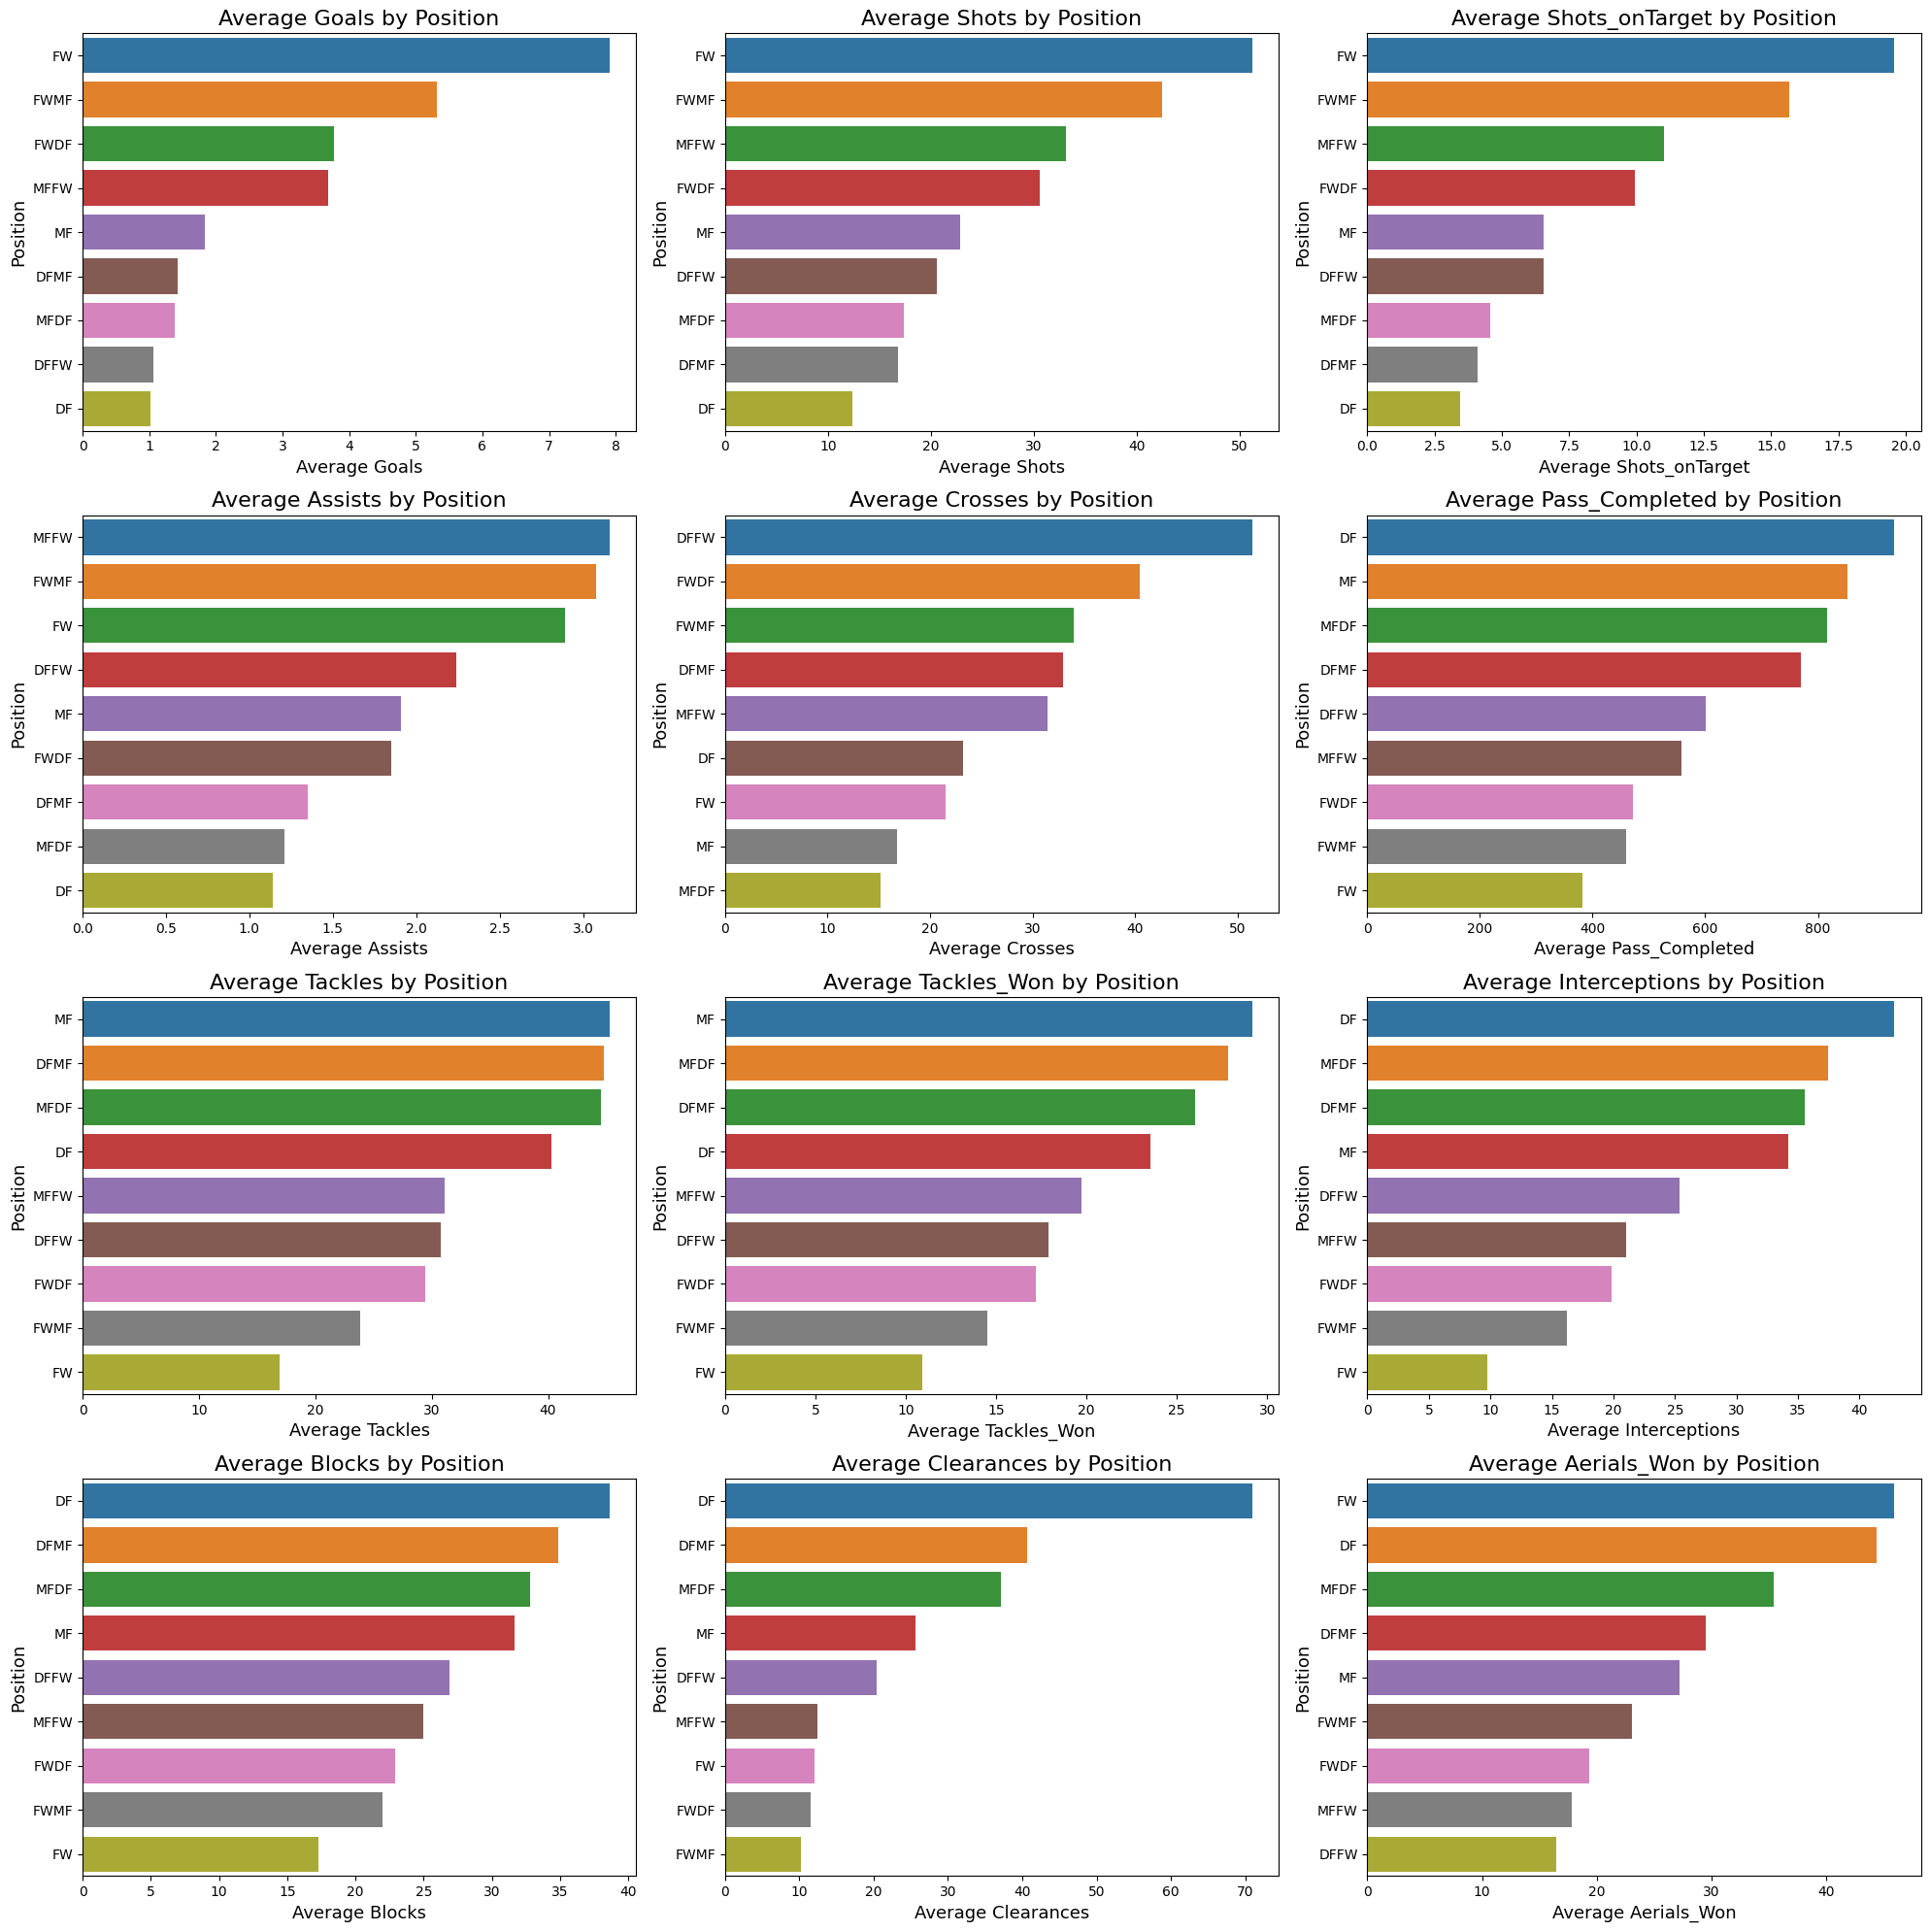

In [17]:
# Creating a grid of subplots (4x3) for the bar charts
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.tight_layout(pad=6.0)

# Iterating over the metrics and plotting them in the subplot grid
for i, metric in enumerate(metrics):
    # Calculate the row and column index for the current subplot
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Sorting data for the current metric in descending order
    sorted_data = pos_metrics_avg_1[metric].sort_values(ascending=False)
    
    # Creating the bar plot
    sns.barplot(x=sorted_data.values, y=sorted_data.index, ax=ax)
    ax.set_title(f'Average {metric} by Position',fontsize=16)
    ax.set_xlabel(f'Average {metric}',fontsize=13)
    ax.set_ylabel('Position',fontsize=13)

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Display the plots
plt.show()

In [62]:
# Assuming 'pos_metrics_avg_1' is your DataFrame, and 'metrics' contains your list of metrics
rows = 4  # Number of rows for subplots
cols = 3  # Number of columns for subplots

# Create a subplot figure
fig = make_subplots(rows=rows, cols=cols, subplot_titles=metrics)

# Loop through each metric and add a bar plot to the figure
for i, metric in enumerate(metrics):
    row = i // cols + 1
    col = i % cols + 1
    sorted_data = pos_metrics_avg_1[metric].sort_values(ascending=True)
    fig.add_trace(go.Bar(y=sorted_data.index, x=sorted_data.values, orientation='h'), row=row, col=col)

# Update layout of the figure
fig.update_layout(height=1200, width=1200, title_text="Average Metrics by Position", showlegend=False)
fig.update_xaxes(title_text="Average")
fig.update_yaxes(title_text="Position")
fig.show()



In [75]:
# Selecting a few positions for the radar chart
selected_positions = ['FW', 'MF', 'DF', 'FWMF', 'MFFW', 'DFMF', 'MFDF', 'DFFW', 'FWDF']

# Assuming 'pos_metrics_avg_1' is your DataFrame, 'metrics' is the list of metrics, and 'selected_positions' are the positions you want to plot
# Normalizing the data
normalized_data = pos_metrics_avg_1.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
selected_data = normalized_data.loc[selected_positions]

# Number of variables we're plotting
num_vars = len(metrics)

# Create a radar chart for each position
fig = go.Figure()

# Adding each position's data to the radar chart
for position in selected_positions:
    fig.add_trace(go.Scatterpolar(
        r=selected_data.loc[position].tolist() + [selected_data.loc[position][0]],
        theta=metrics + [metrics[0]],
        fill='toself',
        name=position
    ))

# Update the layout to make the chart larger
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    title_text='Performance Profile by Position',
    height=800,  # Height of the chart in pixels
    width=800   # Width of the chart in pixels
)

fig.show()


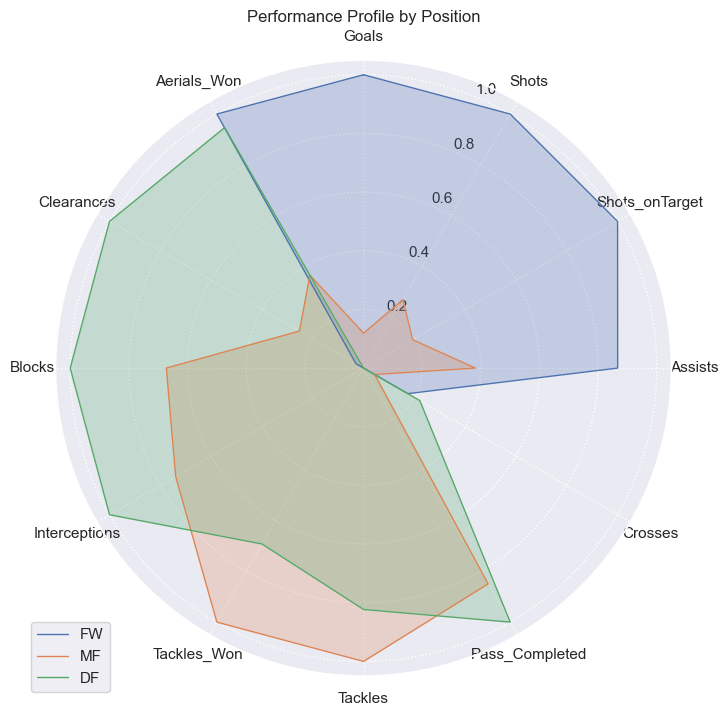

In [69]:
# Selecting a few positions for the radar chart
selected_positions = ['FW', 'MF', 'DF']

# Normalizing the data for radar chart
normalized_data = pos_metrics_avg_1.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
selected_data = normalized_data.loc[selected_positions]

# Number of variables we're plotting (number of metrics)
num_vars = len(metrics)

# Creating angles for each axis in the plot (divide the plot / number of variables)
#angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [angles[0]]

# Calculate the angles for each axis in the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plotting the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for position in selected_positions:
    values = normalized_data.loc[position].tolist() + [normalized_data.loc[position].tolist()[0]]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=position)
    ax.fill(angles, values, alpha=0.25)

# Adding labels for each metric
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Adding legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Performance Profile by Position')

# Displaying the plot
plt.show()

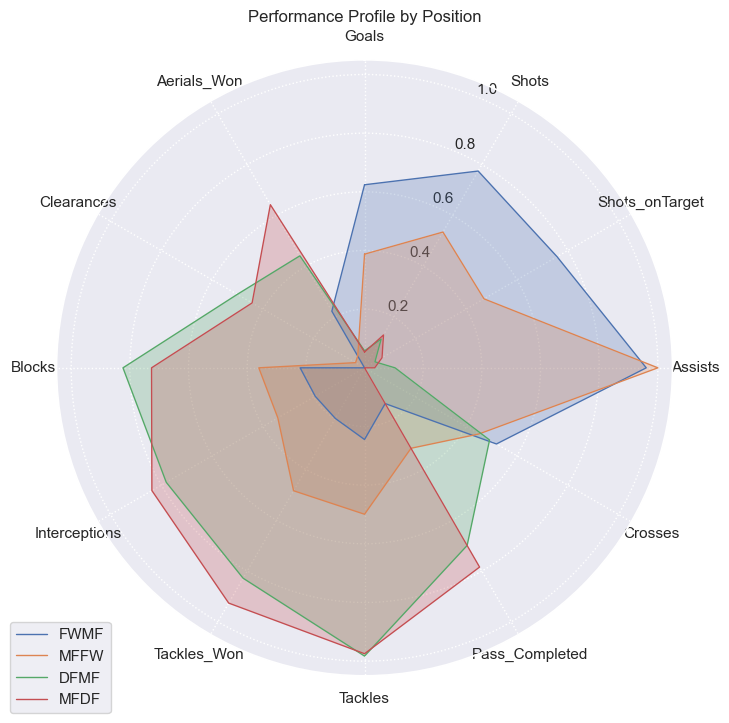

In [73]:

# 'metrics' should be a list of your metrics columns names
normalized_data = pos_metrics_avg_1.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
selected_positions = ['FWMF', 'MFFW', 'DFMF', 'MFDF']  # Example positions

# Number of variables (metrics)
num_vars = len(metrics)

# Calculate the angles for each axis in the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Create a radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for position in selected_positions:
    values = normalized_data.loc[position].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=position)
    ax.fill(angles, values, alpha=0.25)

# Add labels for each metric
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Add a legend and a title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Performance Profile by Position')

# Display the plot
plt.show()



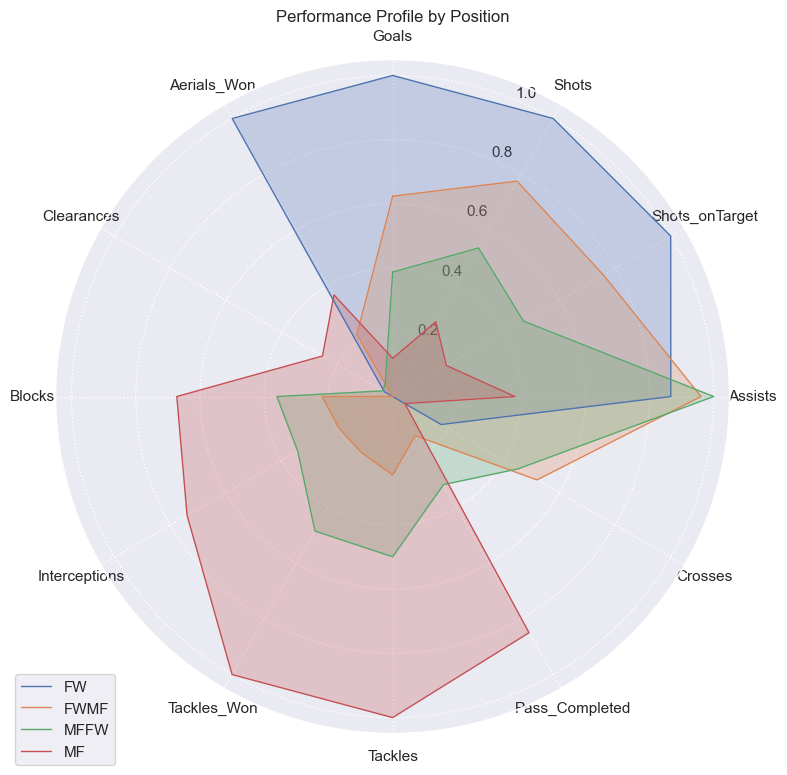

In [67]:
# Selecting a few positions for the radar chart
selected_positions = ['FW', 'FWMF', 'MFFW', 'MF']

# Normalizing the data for radar chart
normalized_data = pos_metrics_avg_1.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
selected_data = normalized_data.loc[selected_positions]

# Number of variables we're plotting (number of metrics)
num_vars = len(metrics)

# Creating angles for each axis in the plot (divide the plot / number of variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [angles[0]]

# Plotting the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for position in selected_positions:
    values = normalized_data.loc[position].tolist() + [normalized_data.loc[position].tolist()[0]]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=position)
    ax.fill(angles, values, alpha=0.25)

# Adding labels for each metric
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Adding legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Performance Profile by Position')
# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()
# Displaying the plot
plt.show()

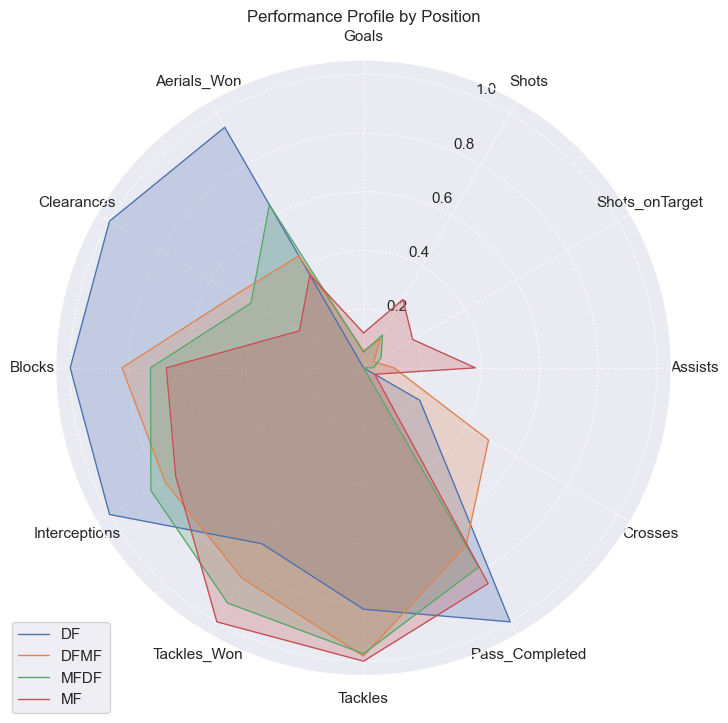

In [68]:
# Selecting a few positions for the radar chart
selected_positions = ['DF', 'DFMF', 'MFDF', 'MF']

# Normalizing the data for radar chart
normalized_data = pos_metrics_avg_1.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
selected_data = normalized_data.loc[selected_positions]

# Number of variables we're plotting (number of metrics)
num_vars = len(metrics)

# Creating angles for each axis in the plot (divide the plot / number of variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [angles[0]]

# Plotting the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for position in selected_positions:
    values = normalized_data.loc[position].tolist() + [normalized_data.loc[position].tolist()[0]]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=position)
    ax.fill(angles, values, alpha=0.25)

# Adding labels for each metric
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Adding legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Performance Profile by Position')

# Displaying the plot
plt.show()

## Key Findings:
##### 1. Offensive Metrics (Goals, Assists, Shots, SoT):
* FW (Forwards) dominate in goals, shots, and shots on target.
* FWMF (Forward-Midfield) and MFFW (Midfield-Forward) also perform well in these metrics, indicating their offensive roles.
##### 2. Passing (PasTotCmp, PasTotAtt):
* DF (Defenders) and MFDF (Midfield-Defenders) lead in passes completed and attempted, suggesting strong involvement in build-up play and ball distribution.
##### 3. Defensive Metrics (Tkl, TklWon, Int, Blocks, Clr):
* DFMF (Defender-Midfield) and MFDF excel in tackles, interceptions, and blocks, reflecting their defensive responsibilities.
* DF players have the highest clearances, crucial for defensive actions.

## Interpretation:
* Forwards (FW) are the primary attacking force, as expected, with the highest averages in goals and attacking actions.
* Midfielders (MF) and Defenders (DF), especially those with mixed roles like DFMF and MFDF, show a balance in both offensive (assists) and defensive contributions (tackles, interceptions).
* Goalkeepers (GK), as expected, have negligible contributions in outfield metrics but are included for completeness.
This analysis provides a detailed understanding of each position's role and contribution on the field. It highlights the multifaceted responsibilities of players, especially those in hybrid roles like DFMF and MFDF, who contribute significantly to both defense and attack. Such insights can be valuable for team strategy, player evaluation, and training focus.

# Statistical Analysis (Players 2021-2022)

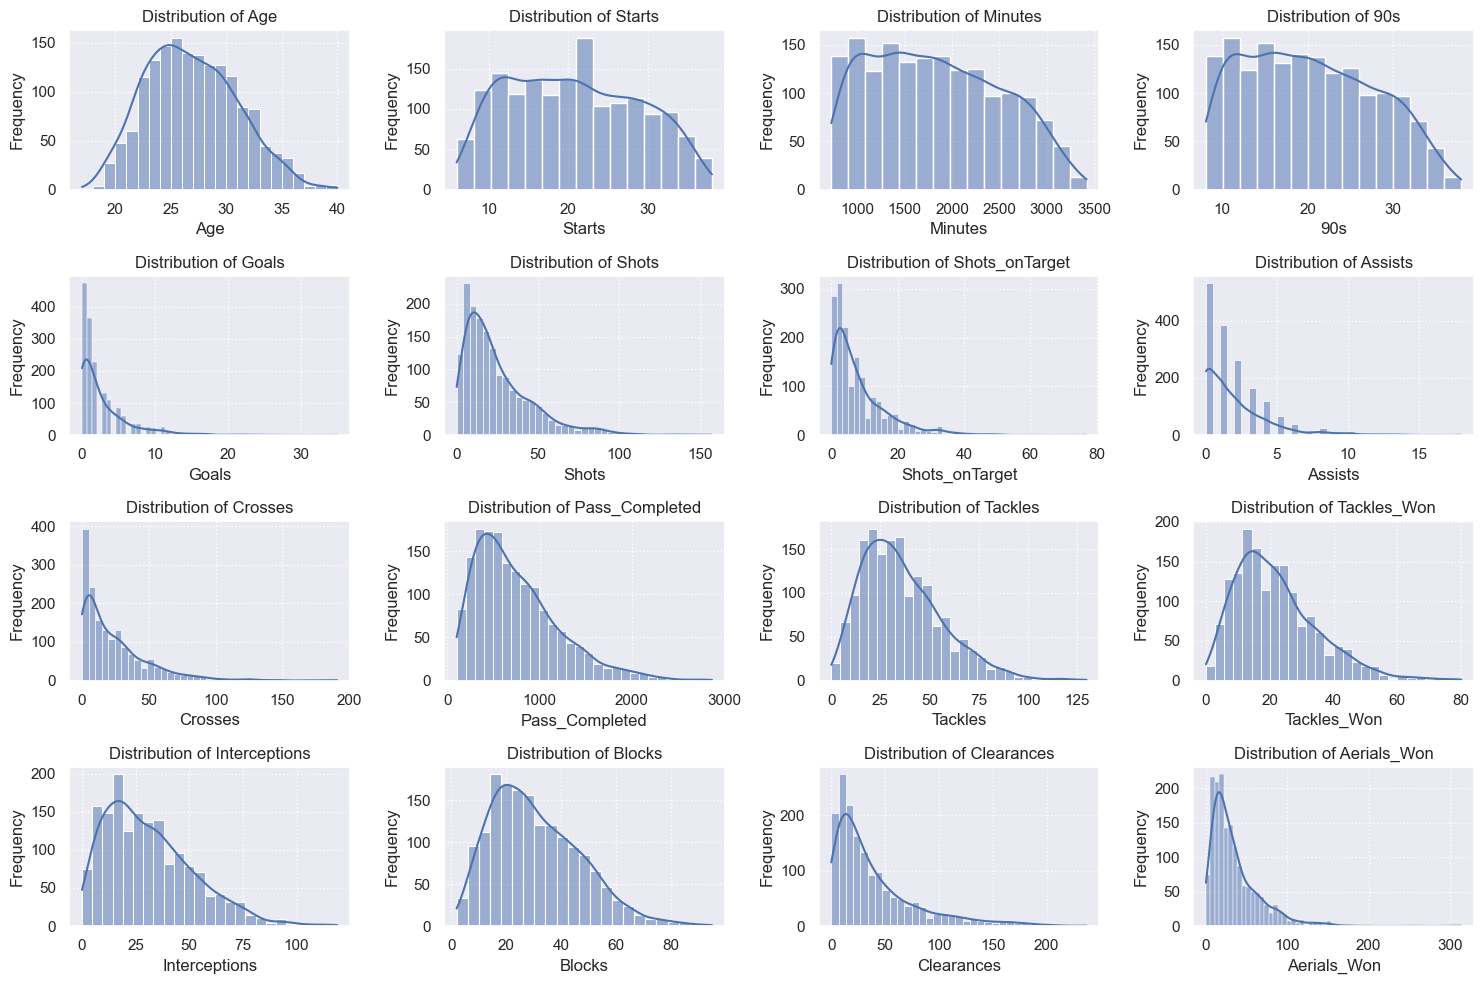

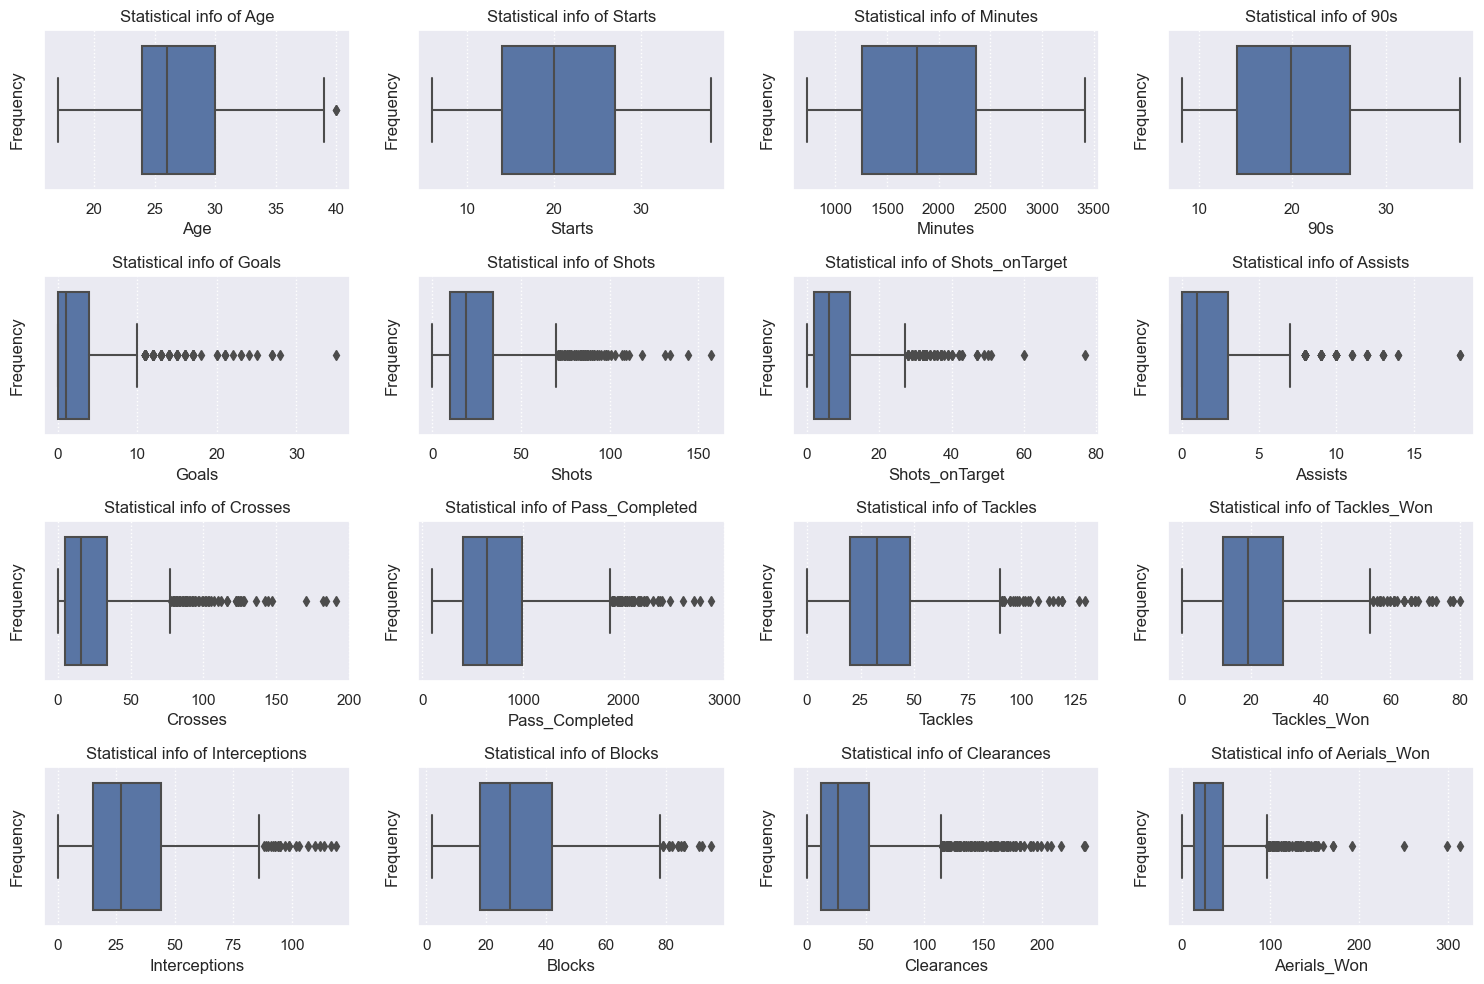

In [50]:
# Creating a histogram plot for each metric
plt.figure(figsize=(15, 10))
sns.set_style("darkgrid", {'grid.linestyle': ':'})
for e, col in enumerate(numerical_col):
    plt.subplot(4, 4, e+1)
    sns.histplot(players_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()


# Creating a box plot for each metric
plt.figure(figsize=(15, 10))
sns.set_style("darkgrid", {'grid.linestyle': ':'})
for e, col in enumerate(numerical_col):
    plt.subplot(4, 4, e+1)
    sns.boxplot(x=players_df[col])
    plt.title(f'Statistical info of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

In [55]:
# Assuming 'players_df' is your DataFrame and 'numerical_col' contains your numerical columns
rows = 4  # Number of rows for subplots
cols = 4  # Number of columns for subplots

# Create a subplot figure
fig = make_subplots(rows=rows, cols=cols, subplot_titles=numerical_col)

# Loop through each numerical column and add a boxplot to the figure
for i, col in enumerate(numerical_col):
    row = i // cols + 1
    col_num = i % cols + 1
    fig.add_trace(go.Box(y=players_df[col], name=col), row=row, col=col_num)

# Update layout of the figure
fig.update_layout(height=1200, width=1200, title_text="Statistical Information of Numerical Columns")
fig.show()


# Dealing with Outliers

In [21]:
players_df.describe()

,Age,Matches_Played,Starts,Minutes,90s,Goals,Shots,Shots_onTarget,Assists,Crosses,Pass_Completed,Tackles,Tackles_Won,Interceptions,Blocks,Clearances,Aerials_Won
count,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000,1648.000000
mean,26.768204,26.473908,20.714806,1831.108010,20.345024,2.819175,25.127427,8.294296,1.936286,23.696602,750.436286,35.912015,21.968447,31.332524,30.918083,39.330097,35.326456
std,4.075148,6.788275,8.116261,680.831169,7.563327,3.837162,21.185354,8.614255,2.348547,25.406355,456.853351,20.559600,13.090465,20.742498,16.246917,39.530935,30.795547
min,17.000000,11.000000,6.000000,725.000000,8.100000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,24.000000,21.000000,14.000000,1257.000000,14.000000,0.000000,10.000000,2.000000,0.000000,5.000000,403.750000,20.000000,12.000000,15.000000,18.000000,12.000000,14.000000
50%,26.000000,28.000000,20.000000,1786.000000,19.800000,1.000000,19.000000,6.000000,1.000000,16.000000,648.000000,32.500000,19.000000,27.000000,28.000000,26.000000,26.000000
75%,30.000000,32.000000,27.000000,2361.000000,26.200000,4.000000,34.000000,12.000000,3.000000,34.000000,992.000000,48.000000,29.000000,44.000000,42.000000,53.000000,47.000000
max,40.000000,38.000000,38.000000,3420.000000,38.000000,35.000000,157.000000,77.000000,18.000000,191.000000,2866.000000,130.000000,80.000000,119.000000,95.000000,237.000000,314.000000


### Removing Outliers

In [22]:
# Defining a function to remove outliers using the IQR method for each metric in the dataset
def remove_outliers(df, column_list):
    for column in column_list:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Applying the function to the dataset
# 'filtered_final' is our DataFrame and 'key_metrics' contains the list of metrics

# A) REMOVING OUTLIERS
removed_df = remove_outliers(players_df, numerical_col)

print('players_df with Outliers: ', players_df.shape)
print('removed_df after removing outliers: ', removed_df.shape)

players_df with Outliers:  (1648, 22)
removed_df after removing outliers:  (1121, 22)


## Statistical Analysis (Players removed outliers)

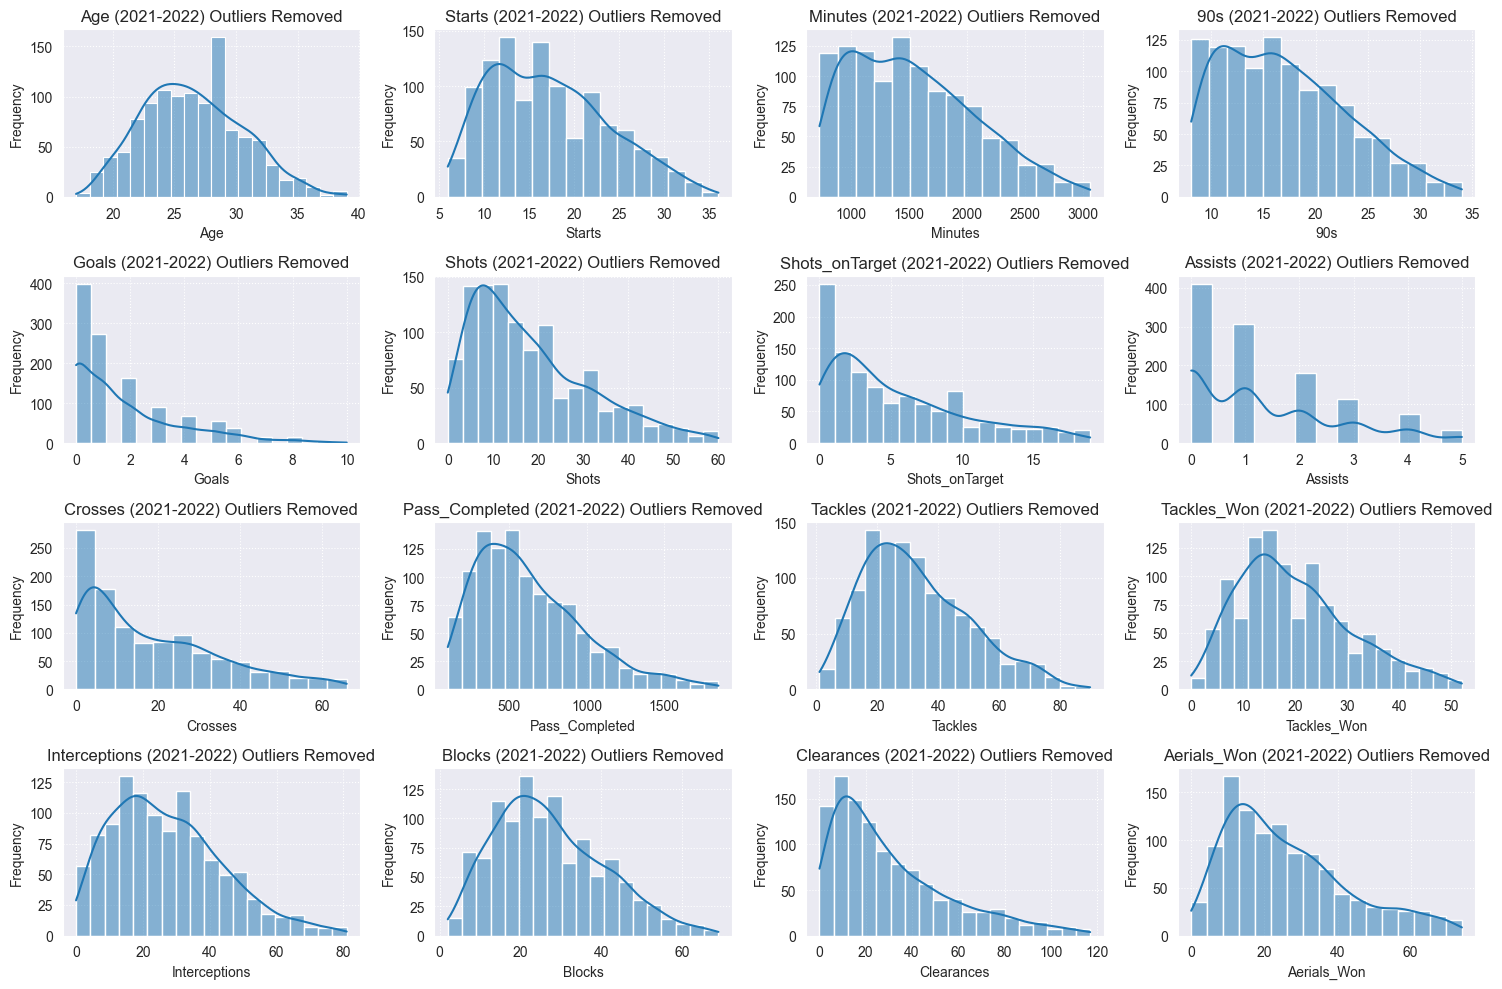

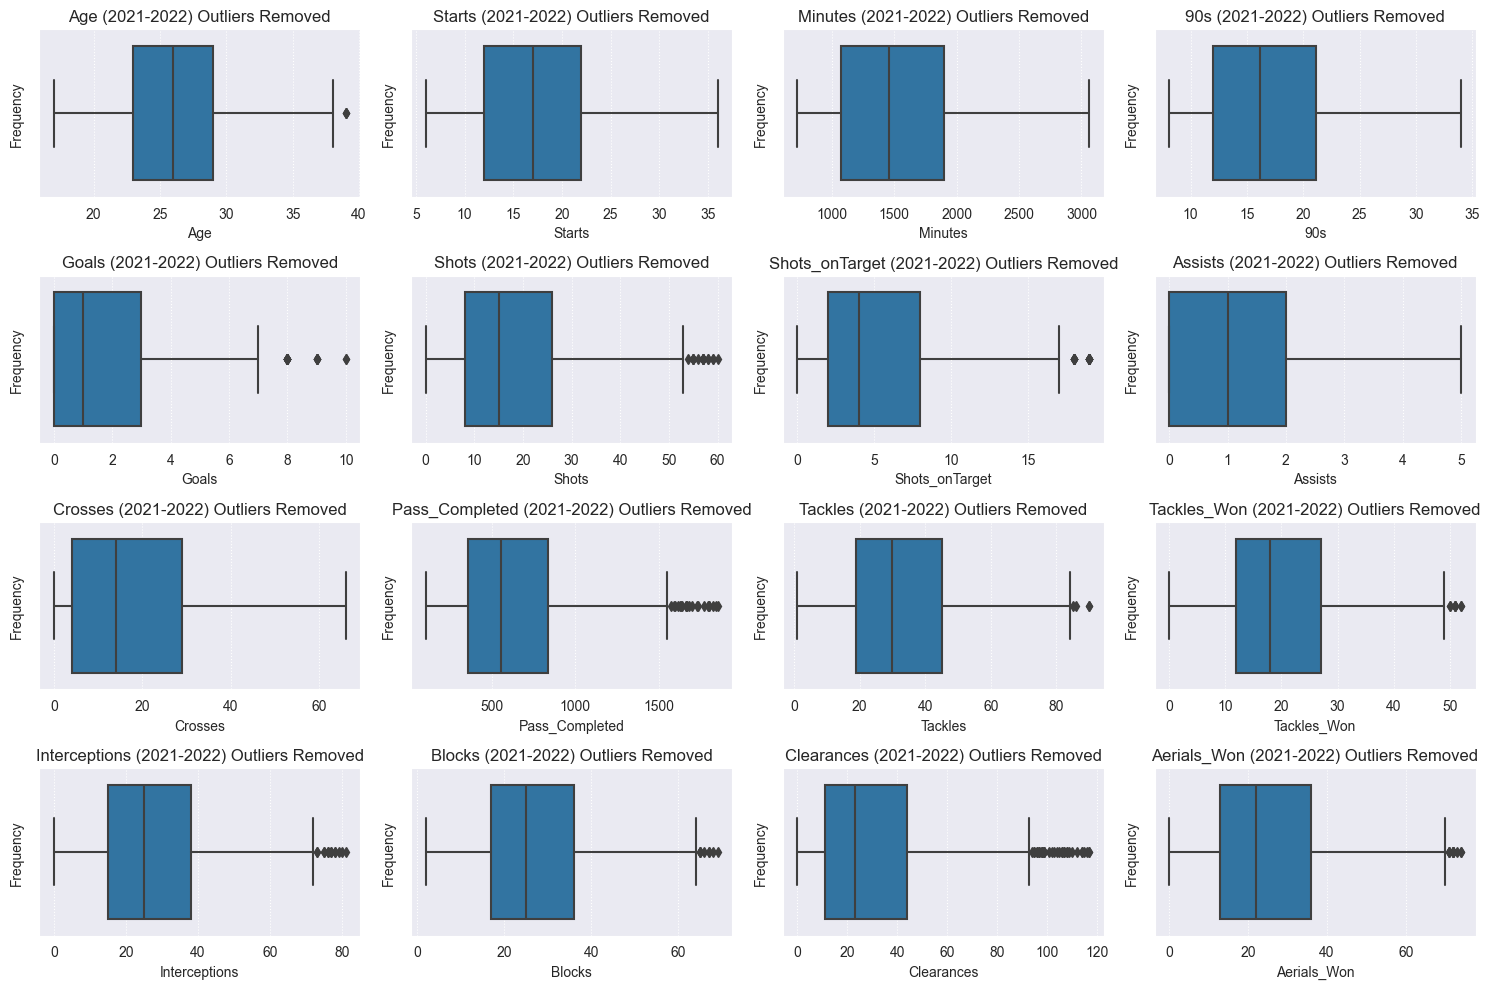

In [23]:
# Creating a histogram plot for each metric
plt.figure(figsize=(15, 10))
sns.set_style("darkgrid", {'grid.linestyle': ':'})
for e, col in enumerate(numerical_col):
    plt.subplot(4, 4, e+1)
    sns.histplot(removed_df[col], kde=True)
    plt.title(f'{col} (2021-2022) Outliers Removed')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()


# Creating a box plot for each metric
plt.figure(figsize=(15, 10))
sns.set_style("darkgrid", {'grid.linestyle': ':'})
for e, col in enumerate(numerical_col):
    plt.subplot(4, 4, e+1)
    sns.boxplot(x=removed_df[col])
    plt.title(f'{col} (2021-2022) Outliers Removed')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

In [56]:

# Assuming 'players_df' is your DataFrame and 'numerical_col' contains your numerical columns
rows = 4  # Number of rows for subplots
cols = 4  # Number of columns for subplots

# Create a subplot figure
fig = make_subplots(rows=rows, cols=cols, subplot_titles=numerical_col)

# Loop through each numerical column and add a boxplot to the figure
for i, col in enumerate(numerical_col):
    row = i // cols + 1
    col_num = i % cols + 1
    fig.add_trace(go.Box(y=removed_df[col], name=col), row=row, col=col_num)

# Update layout of the figure
fig.update_layout(height=1200, width=1200, title_text="Statistical Information of Numerical Columns")
fig.show()


In [24]:
# CHECK THE VALUES WORK AFTER ADJUSTMENT (PLAYERS 2021-2022)
top_goals1 = players_df.iloc[:,:11]
top_goals1.sort_values(by='Goals', ascending=False).head()

,Player,Nation,Position,Squad,Competition,Age,Matches_Played,Starts,Minutes,90s,Goals
1512,Robert Lewandowski,POL,FW,Bayern Munich,Bundesliga,33,34,34,2946,32.7,35
1720,Kylian Mbappé,FRA,FW,Paris S-G,Ligue 1,23,35,34,3023,33.6,28
284,Karim Benzema,FRA,FW,Real Madrid,La Liga,34,32,31,2593,28.8,27
1236,Ciro Immobile,ITA,FW,Lazio,Serie A,32,31,31,2711,30.1,27
265,Wissam Ben Yedder,FRA,FW,Monaco,Ligue 1,31,37,29,2529,28.1,25


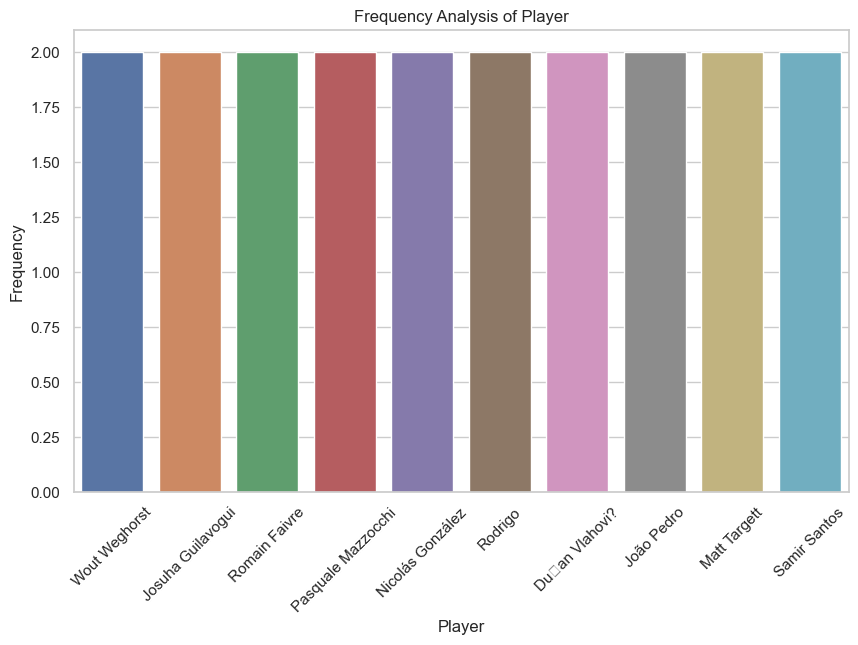

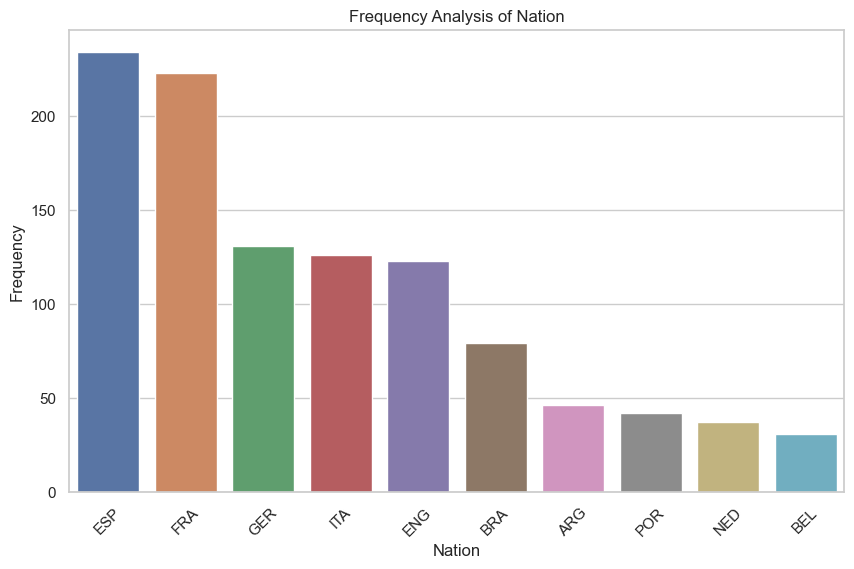

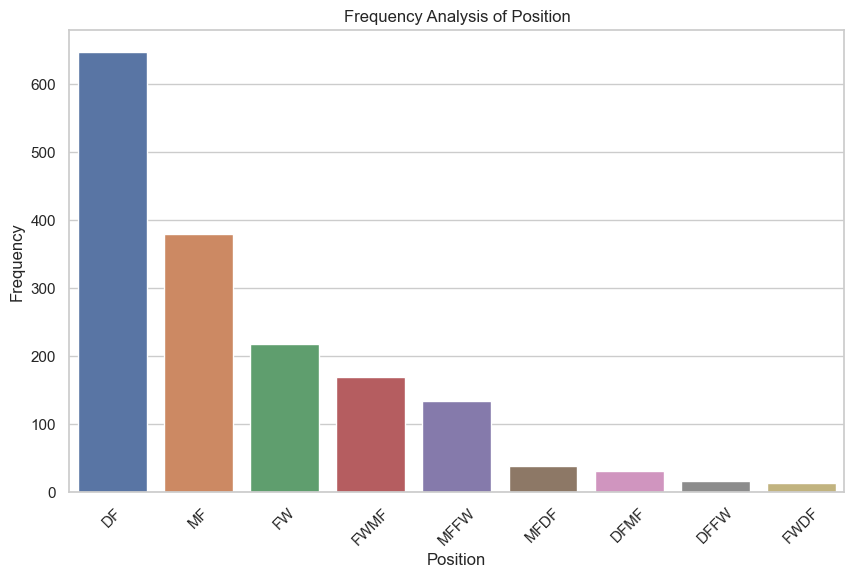

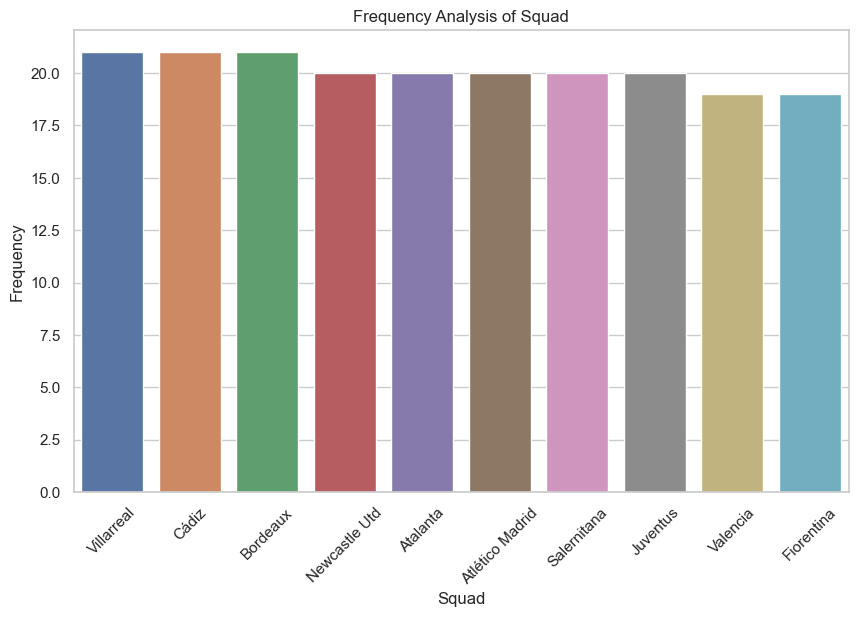

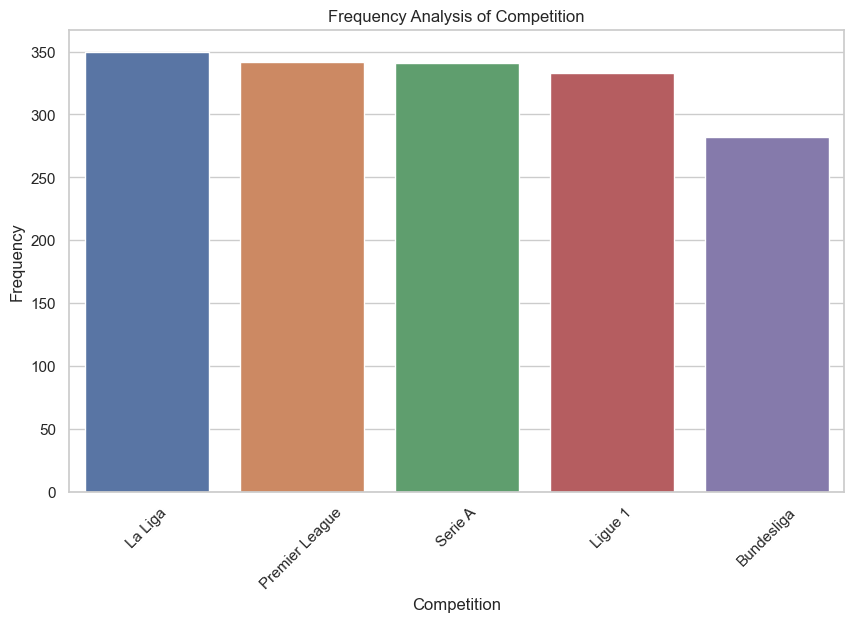

In [25]:
# List of categorical columns
categorical_col

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Use a for loop to create a plot for each categorical column
for col in categorical_col:
    plt.figure(figsize=(10, 6))
    frequency = players_df[col].value_counts().head(10)
    sns.barplot(x=frequency.index, y=frequency.values)
    plt.title(f'Frequency Analysis of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)  # Rotate labels for better readability if needed
    plt.show()

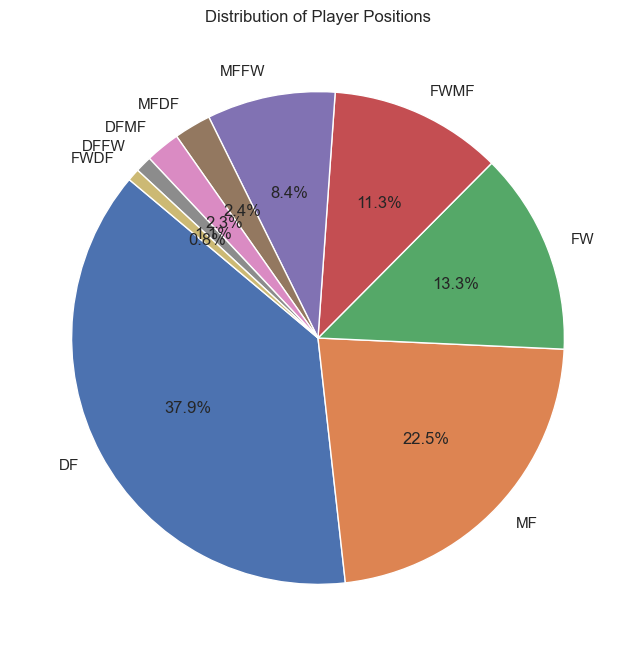

In [ ]:
position_counts = players_df['Position'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Player Positions')
plt.show()

In [57]:

# Assuming 'players_df' has a column 'Position' with player positions
position_counts = players_df['Position'].value_counts()

# Creating a pie chart using Plotly Express
fig = px.pie(position_counts, values=position_counts, names=position_counts.index, title='Distribution of Player Positions')
fig.update_traces(textinfo='percent+label')
fig.show()



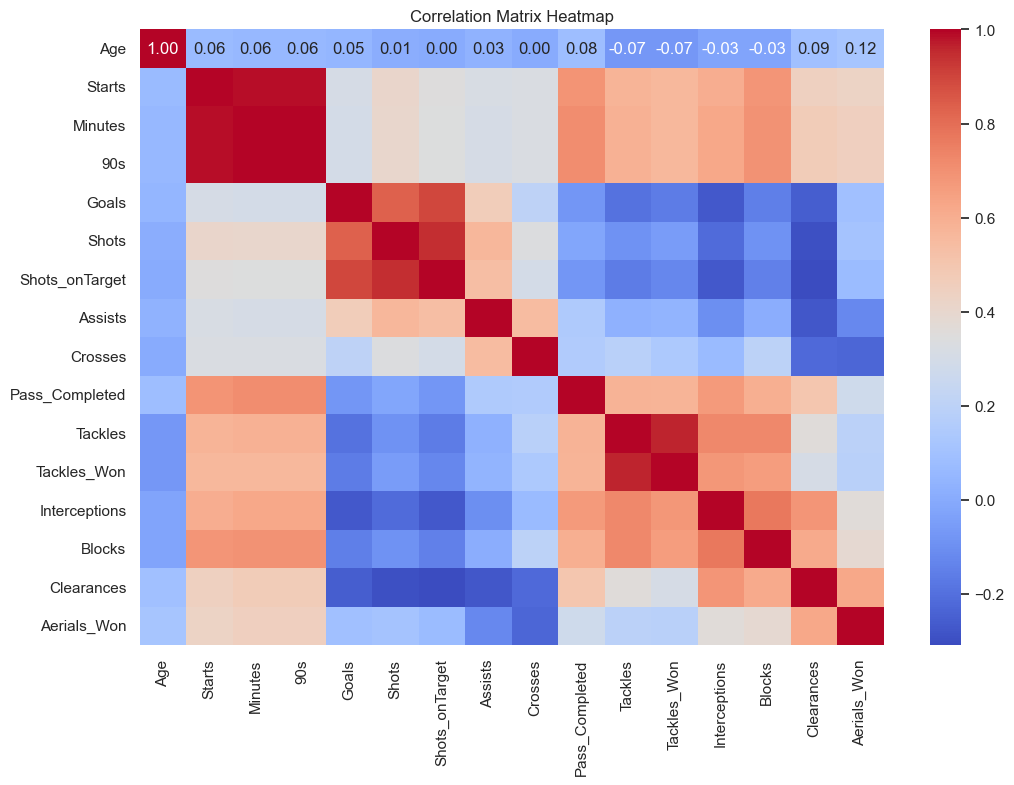

In [26]:
# Calculating the correlation matrix
corr_matrix = players_df.loc[:,numerical_col].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# MODEL BUILDING, TRAINING & VALIDATING

In [27]:
#scaling data
col = players_df[numerical_col].columns
scaler = StandardScaler()
# players 2021-2022
scaled = scaler.fit_transform(players_df[numerical_col])
scaled_df = pd.DataFrame(scaled,columns=numerical_col)

# print scaled dataframe
scaled_df.head()

,Age,Starts,Minutes,90s,Goals,Shots,Shots_onTarget,Assists,Crosses,Pass_Completed,Tackles,Tackles_Won,Interceptions,Blocks,Clearances,Aerials_Won
0,-1.170424,1.390865,1.542542,1.541453,-0.734926,-0.572618,-0.730906,0.027137,0.838761,0.739113,1.609858,1.148631,1.189585,3.391329,0.776081,-0.660246
1,1.775148,1.637358,1.692404,1.686936,-0.213549,-0.336534,-0.266418,-0.824712,-0.854242,1.161696,1.269281,1.836363,3.456152,1.913677,1.687037,1.028823
2,-1.170424,1.021124,0.926931,0.933070,-0.474238,-0.336534,-0.382540,-0.824712,-0.539265,1.711273,0.928704,0.919387,0.948461,-0.241232,-0.615657,-0.367907
3,0.547826,1.637358,1.652735,1.647259,-0.734926,0.230067,-0.150296,0.027137,0.090690,1.279932,3.945242,3.899559,2.539880,1.482695,-0.716874,-0.692728
4,-0.679495,1.883852,1.840797,1.845644,3.696777,3.204722,2.752751,0.878986,0.011945,-0.546153,-0.093027,0.002411,-0.787633,0.128181,-0.210787,1.516054


# Clustering Teams Based on Metrics (Unsupervised Learning)

## 1. K-Means Clustring

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


silhouette_scores_1 = []
for k in range(2, 11):  # Assuming you want to test cluster counts from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_scores_1.append(score)

# Find the number of clusters with the highest Silhouette Score
optimal_clusters_1 = range(2, 11)[silhouette_scores_1.index(max(silhouette_scores_1))]
optimal_clusters_1, silhouette_scores_1

(3,
 [0.28566795687203755,
  0.30278376289096254,
  0.20298533362089782,
  0.1970743752606696,
  0.18646286840213858,
  0.18541185411166933,
  0.1539692682394027,
  0.14418849420466529,
  0.14418923354378912])

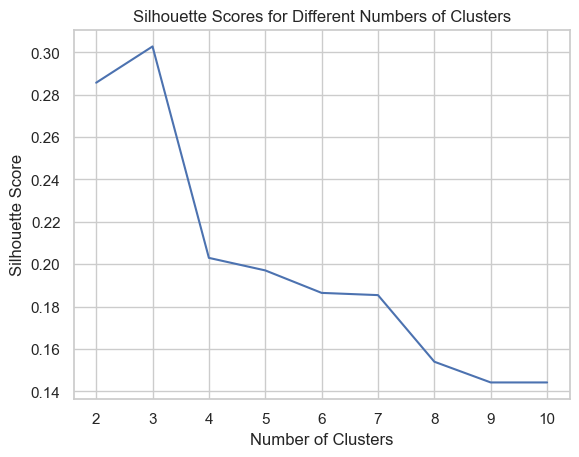

In [29]:
plt.plot(range(2, 11), silhouette_scores_1)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


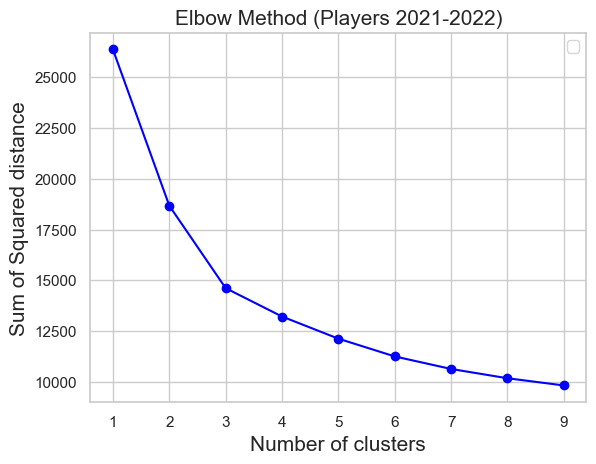

In [30]:
# plot elbow curve
elb1 = []
elb2 = []
krange = range(1,10)

for k in krange:
    km1 = KMeans(n_clusters=k)
    km1.fit(scaled_df)
    elb1.append(km1.inertia_)

plt.plot(krange, elb1, marker='o', color='blue')
plt.title('Elbow Method (Players 2021-2022)',fontsize=15)
plt.xlabel('Number of clusters',fontsize=15)
plt.ylabel('Sum of Squared distance',fontsize=15)
plt.legend()
plt.show()

In [31]:
## clusters
km_model = KMeans(n_clusters=3)
kmean_cluster = km_model.fit_predict(scaled_df)
#count number of records in every cluster
pd.Series(kmean_cluster).value_counts()

1    816
2    557
0    275
Name: count, dtype: int64

In [32]:
player_cluster_df = pd.DataFrame(players_df)
player_cluster_df['km_cluster'] = kmean_cluster
player_cluster_df[['Player', 'Position', 'Squad', 'Competition', 'km_cluster']]

,Player,Position,Squad,Competition,km_cluster
0,Max Aarons,DF,Norwich City,Premier League,2
1,Yunis Abdelhamid,DF,Reims,Ligue 1,2
2,Salis Abdul Samed,MF,Clermont Foot,Ligue 1,2
3,Laurent Abergel,MF,Lorient,Ligue 1,2
7,Tammy Abraham,FW,Roma,Serie A,0
...,...,...,...,...,...
2915,Igor Zubeldia,DF,Real Sociedad,La Liga,1
2916,Martín Zubimendi,MF,Real Sociedad,La Liga,2
2917,Szymon ?urkowski,MF,Empoli,Serie A,2
2918,Martin Ødegaard,MF,Arsenal,Premier League,0


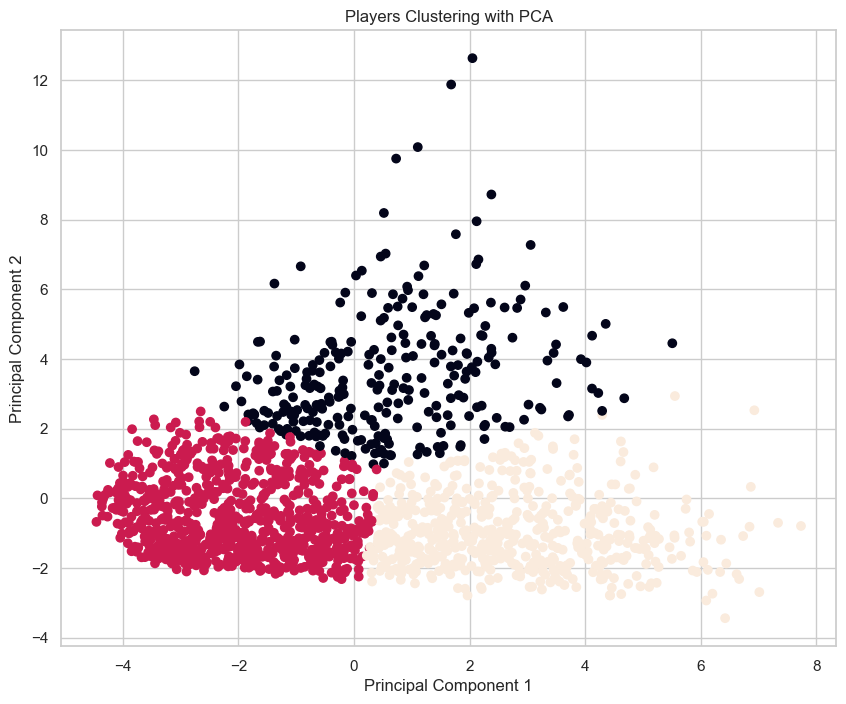

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)

plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmean_cluster)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Players Clustering with PCA')
plt.show()

In [34]:
# Assuming 'scaled_data' is your standardized dataset and 'clusters' contains your cluster labels
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)

# Create a DataFrame for Plotly
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = kmean_cluster

# Plot
fig = px.scatter(df_pca, x='PC1', y='PC2', color='Cluster', title='PCA Cluster Visualization')
fig.show()


In [ ]:
player_cluster_df.head()

,Player,Nation,Position,Squad,Competition,Age,Matches_Played,Starts,Minutes,90s,Goals,Shots,Shots_onTarget,Assists,Crosses,Pass_Completed,Tackles,Tackles_Won,Interceptions,Blocks,Clearances,Aerials_Won,km_cluster
0,Max Aarons,ENG,DF,Norwich City,Premier League,22,34,32,2881,32.0,0,13,2,2,45,1088,69,37,56,86,70,15,2
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,34,34,2983,33.1,2,18,6,0,2,1281,62,46,103,62,106,67,2
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,31,29,2462,27.4,1,18,5,0,10,1532,55,34,51,27,15,24,2
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,34,34,2956,32.8,0,30,7,2,26,1335,117,73,84,55,11,14,2
7,Tammy Abraham,ENG,FW,Roma,Serie A,24,37,36,3084,34.3,17,93,32,4,24,501,34,22,15,33,31,82,1


In [ ]:
cluster1_stats = player_cluster_df.iloc[:,6:].groupby('km_cluster').mean()
print(cluster1_stats)

            Matches_Played     Starts      Minutes        90s     Goals      Shots  Shots_onTarget   Assists    Crosses  Pass_Completed    Tackles  Tackles_Won  Interceptions     Blocks  Clearances  Aerials_Won
km_cluster                                                                                                                                                                                                        
0                21.862745  13.944853  1262.159314  14.024877  1.625000  17.023284        5.398284  1.236520  16.707108      479.262255  24.917892    15.189951      20.340686  21.247549   24.138480    23.378676
1                32.181159  26.934783  2322.115942  25.799638  8.836957  60.590580       22.789855  4.800725  45.217391      702.619565  29.195652    18.336957      20.260870  26.764493   15.673913    37.079710
2                30.408273  27.562950  2422.374101  26.912950  1.584532  19.417266        5.348921  1.541367  23.271583     1172.154676  55.381295    33.719

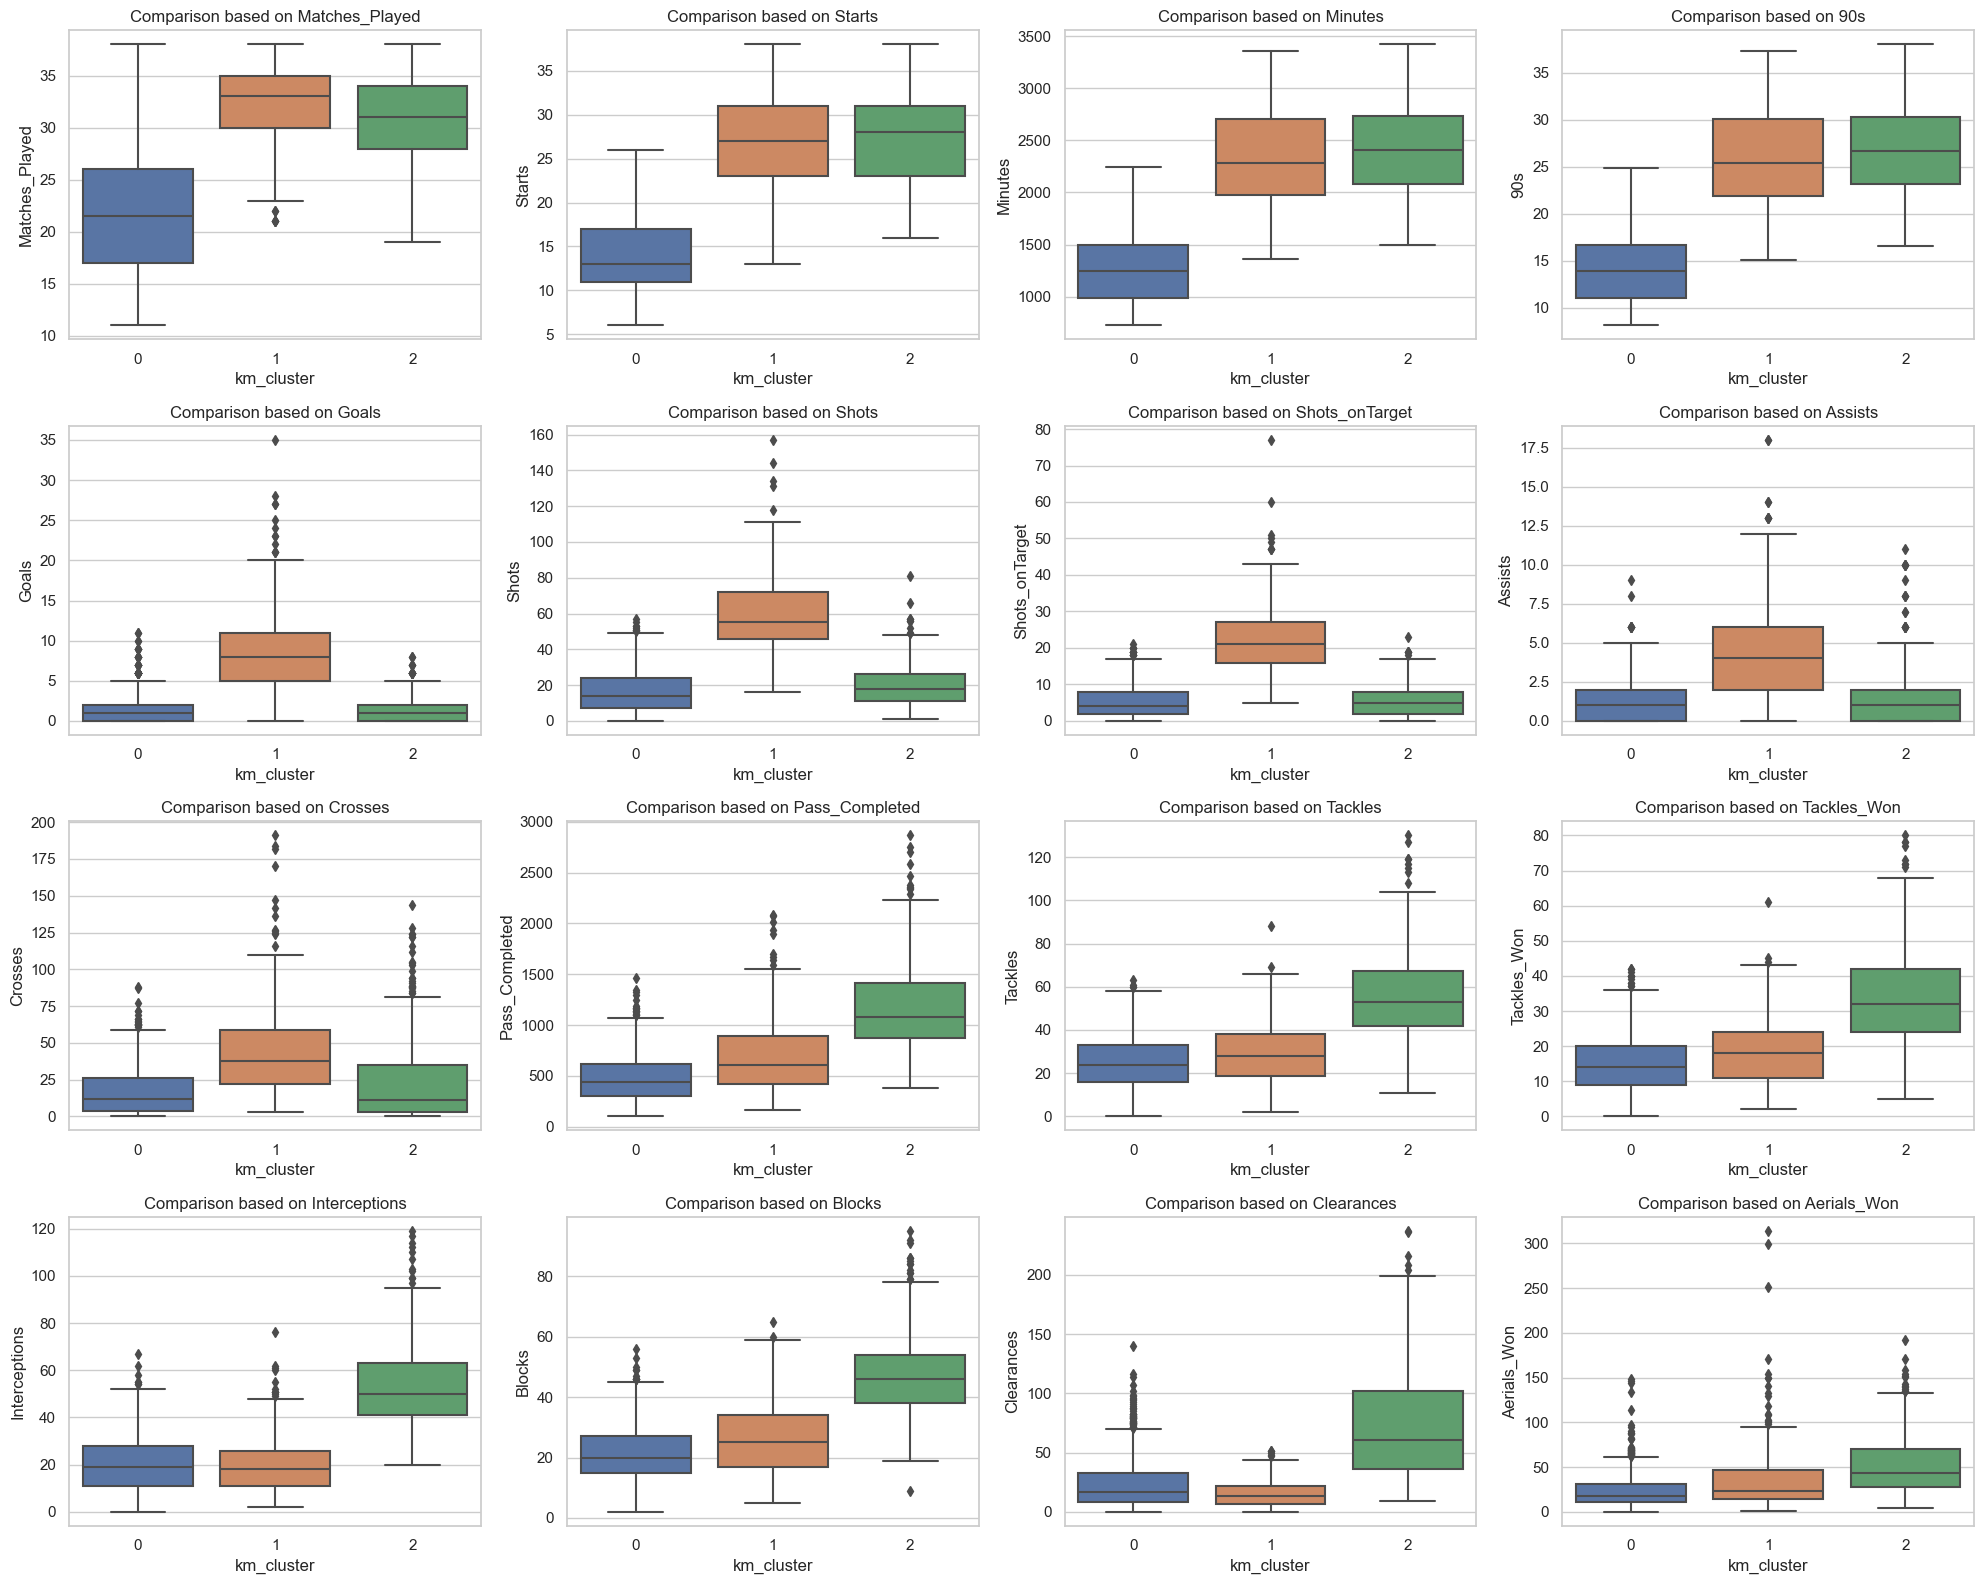

In [ ]:

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Loop through the features and create a subplot for each feature
for i, feature in enumerate(cluster1_stats.columns, 1):
    plt.subplot(4, 4, i)  # Adjust the grid dimensions (2, 3) based on the number of features
    sns.boxplot(x='km_cluster', y=feature, data=player_cluster_df)
    plt.title(f'Comparison based on {feature}')

plt.tight_layout()
plt.show()

In [ ]:
player_cluster_df[player_cluster_df['km_cluster'] == 0]['Position'].value_counts()

Position
DF      289
MF      187
FW      106
FWMF     95
MFFW     83
MFDF     20
DFMF     15
DFFW     13
FWDF      8
Name: count, dtype: int64

In [ ]:
player_cluster_df[player_cluster_df['km_cluster'] == 1]['Position'].value_counts()

Position
FW      110
FWMF     74
MFFW     42
MF       32
DF       12
FWDF      4
DFMF      1
DFFW      1
Name: count, dtype: int64

In [ ]:
player_cluster_df[player_cluster_df['km_cluster'] == 2]['Position'].value_counts()

Position
DF      346
MF      161
MFDF     18
DFMF     15
MFFW      9
DFFW      3
FW        2
FWMF      1
FWDF      1
Name: count, dtype: int64

In [45]:
player_cluster_df.head()

,Player,Nation,Position,Squad,Competition,Age,Matches_Played,Starts,Minutes,90s,Goals,Shots,Shots_onTarget,Assists,Crosses,Pass_Completed,Tackles,Tackles_Won,Interceptions,Blocks,Clearances,Aerials_Won,km_cluster
0,Max Aarons,ENG,DF,Norwich City,Premier League,22,34,32,2881,32.0,0,13,2,2,45,1088,69,37,56,86,70,15,2
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,34,34,34,2983,33.1,2,18,6,0,2,1281,62,46,103,62,106,67,2
2,Salis Abdul Samed,GHA,MF,Clermont Foot,Ligue 1,22,31,29,2462,27.4,1,18,5,0,10,1532,55,34,51,27,15,24,2
3,Laurent Abergel,FRA,MF,Lorient,Ligue 1,29,34,34,2956,32.8,0,30,7,2,26,1335,117,73,84,55,11,14,2
7,Tammy Abraham,ENG,FW,Roma,Serie A,24,37,36,3084,34.3,17,93,32,4,24,501,34,22,15,33,31,82,0


In [47]:

# Assuming 'data_selected_features' has 'Country' and 'Cluster' columns
fig = px.bar(player_cluster_df, x='Competition', color='km_cluster',  barmode='group',
             title='Country-Wise Distribution of Team Strategies')
fig.show()